### Verify if the dstribution of best GP fits stays fixed

<br>**Author(s):** Weixiang Yu
<br>**Last run:** 07-23-20
<br>**Short description:** This notebook will try to verify whether the distribution of best-fit parameters stays unchanged (for a variaty of seeds) given all other variables stay fixed. (e.g., input values, cadence, photometric noise level and etc.) 

In [1]:
# import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import os, sys

# see if local stores mpl style, else use from src
try:
    plt.style.use('yu_basic')
except:
    mpl.rc_file('https://raw.githubusercontent.com/ywx649999311/project_template'
                '/master/%7B%7Bcookiecutter.project_name%7D%7D/src/vis/mpl/yu_basic.rc')

pd.set_option('display.max_columns', 999)
%matplotlib inline

In [2]:
# import GP modules
from agntk.carma.CARMATerm import *
from agntk.lc.utils import *
from celerite import GP
import dask
from scipy.optimize import minimize

### 1. Generate Mock LCs and fit
We will test for 5 different random seeds and with each seed we will simulate 1000 light curves from the prior distribution

In [3]:
# define log posterior function
def neg_log_prob(params, y, yerr, gp):
    gp.set_parameter_vector(params)
#     amp = gp.kernel.get_rms_amp()
#     model_std = np.sqrt(np.var(y) - np.var(yerr))
    
    # below add a prior using the estimated model std from light curve
    return -gp.log_likelihood(y)

In [58]:
# funtion to parallel LC simulation and fitting with Dask
@dask.delayed
def simLC_fit(tauErrArr, ampErrArr, tau, amp, seed=42, N=100, nLC=1000, duration=3650.0, errAmp=0.0):
    
    # set random seed
    np.random.seed(seed)
    
    # init sim kernel
    kernel = DRW_term(np.log(amp), np.log(tau))
    gp_sim = GP(kernel)

    # first init 10K time stamps
    t = np.linspace(0, duration, 10000)
    yerr = np.random.normal(0, 1e-7, 10000) # give very tiny error
    
    # try if factorize, skip after 10 tries
    factor = True
    fact_num = 0
    
    while factor:
        try:
            gp_sim.compute(t, yerr)
            factor = False
        except Exception as e:
            fact_num += 1
            if fact_num > 10:
                print(e)
                print(f'Failed at seed {seed}!')
                return 1
    
    y = gp_sim.sample(size=nLC)
    ampErr = []
    tauErr = []
    
    for i in range(nLC):
    
        # downsample
        mask1 = add_season(t)
        mask2 = downsample_byN(t[mask1], N) # randomly select N time stamps
        t_fit = t[mask1][mask2] 
        y_fit = y[i, :][mask1][mask2]
        yerr_fit = yerr[mask1][mask2]

        ## start fitting
        # initialize parameter in the possible range
        init_tau = np.exp(np.random.uniform(1, np.log(1000), 1)[0])
        init_amp = np.random.uniform(0, 0.35, 1)[0]

        kernel_fit = DRW_term(np.log(init_amp), np.log(init_tau))
        gp_fit = GP(kernel_fit)
        gp_fit.compute(t_fit, yerr_fit)

        initial_params = gp_fit.get_parameter_vector()
        bounds = gp_fit.get_parameter_bounds()

        r = minimize(neg_log_prob, initial_params, method="L-BFGS-B", bounds=bounds, \
                     args=(y_fit, yerr_fit, gp_fit))

        # compute pecentage err for each LC and add to list
        input_param = np.array([amp, tau])
        err = 100*(np.exp(r.x) - input_param)/input_param
        ampErr.append(err[0])
        tauErr.append(err[1])
        
#         if i == 10:
#             print(r.x)
#             print(err)

    # assign result of result array
    ampErrArr[:] = ampErr
    tauErrArr[:] = tauErr
    
    return 0

In [65]:
# init empty array to store errors
nLC = 1000
nSeed = 4
tauErrArr = np.empty((nSeed, nLC))
ampErrArr = np.empty((nSeed, nLC))

In [66]:
dask_rt = []
seeds = np.random.randint(10, 1000, nSeed)

for i, seed in enumerate(seeds):
    dask_rt.append(simLC_fit(tauErrArr[i,:], ampErrArr[i,:], 50, 0.25, nLC=nLC))

total = dask.delayed(sum)(dask_rt)
sum_n = total.compute()
print(sum_n)

0


### 2. Let's plot the result, see any significant difference in error distribution

Text(0.5, 0, 'Percentage error')

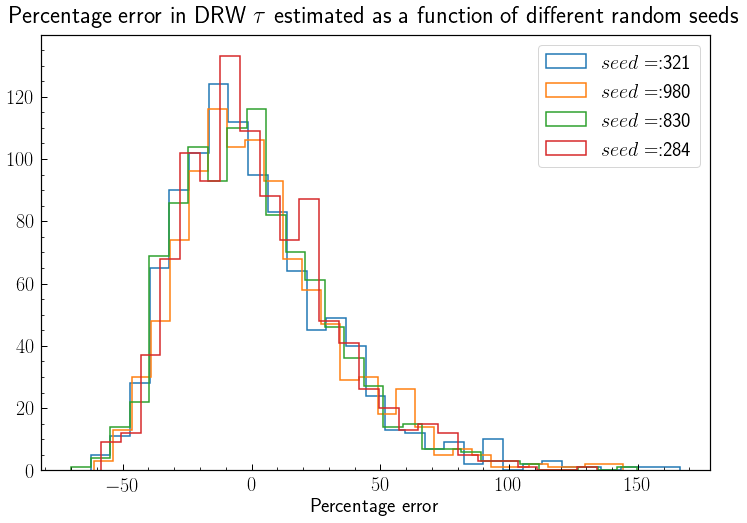

In [72]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(tauErrArr):
        _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, label=f'$seed=$:{seeds[i]}')
plt.title('Percentage error in DRW $\\tau$ estimated as a function of different random seeds')
plt.legend()
plt.xlabel('Percentage error')

Text(0.5, 0, 'Percentage error')

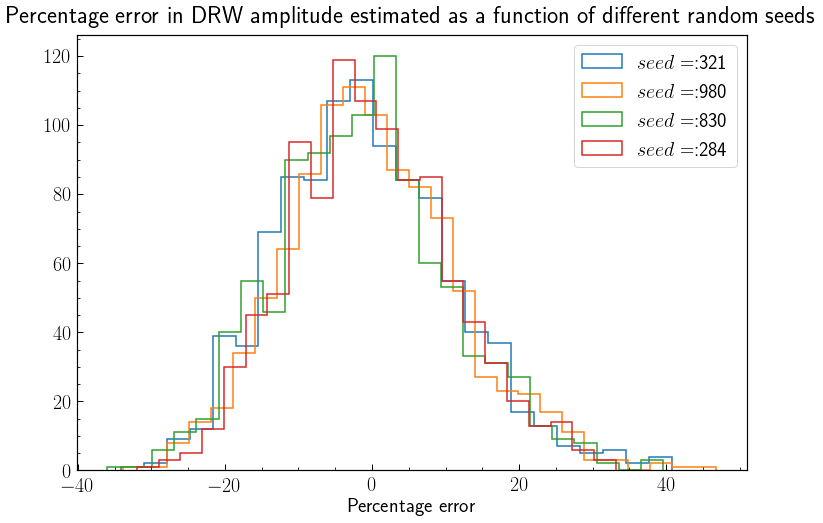

In [71]:
fig = plt.figure(figsize=(12,8))
for i, err in enumerate(ampErrArr):
        _ = plt.hist(err, bins='fd', histtype='step', linewidth=1.5, label=f'$seed=$:{seeds[i]}')
plt.title('Percentage error in DRW amplitude estimated as a function of different random seeds')
plt.legend()
plt.xlabel('Percentage error')